In [1]:
import matplotlib.pyplot as plt  # for plotting images
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import time
import os
import torchvision
from torchvision import transforms

In [2]:
torch.cuda.device(0)
torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [4]:
transform=transforms.Compose([transforms.ToTensor()])

from torchvision.datasets import MNIST

train_data = MNIST(root = './', train=True, download=True, transform=transform)
val_data = MNIST(root = './', train=False, download=True, transform=transform)

In [29]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(val_data, batch_size=500, shuffle=False)

In [30]:
def add_noise(inputs):
     noise = torch.randn_like(inputs)*0.2
     return inputs + noise

In [31]:
class AE(nn.Module):
  def __init__(self):
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Conv2d(1,8,3,stride=1),
            nn.ReLU(),
            nn.Conv2d(8,16,5,stride=1),
            nn.ReLU(),
            nn.Conv2d(16,32,5,stride=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )  # The encoder network
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(32,16,3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16,8,5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8,1,8, stride=1),
            nn.Sigmoid(),
        )  # The decoder network

  def forward(self, features):
      x = self.encoder(features.float())
      return self.decoder(x)


  def encode(self,inp):
    return self.encoder(inp)

  def decode(self, latent):
    return self.decode(latent)


  

In [32]:
model=AE()

In [33]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
step_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 2, gamma= 0.1)
model=model.to(device)

In [38]:
def train(model,trainloader):
    loss_list=[]
    for epoch in range (0,10):
        running_loss=0
        for i,data in enumerate (trainloader):
            X,Y=data
            X=X.to(device)
            Y = Y.to(device)
            optimizer.zero_grad()
            output=model.forward(add_noise(X))
            output=output.to(device)
            loss=criterion(output,X)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i== 1:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %f' %
                    (epoch + 1, 10, running_loss /1000))
            loss_list.append(running_loss/1000)
            running_loss = 0.0
    return loss_list

In [39]:
loss_list=train(model,trainloader=train_loader)

[1,    10] loss: 0.000652
[2,    10] loss: 0.000249
[3,    10] loss: 0.000167
[4,    10] loss: 0.000134
[5,    10] loss: 0.000120
[6,    10] loss: 0.000110
[7,    10] loss: 0.000105
[8,    10] loss: 0.000101
[9,    10] loss: 0.000097
[10,    10] loss: 0.000094


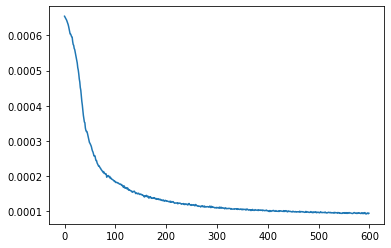

In [40]:
plt.plot(loss_list)

In [42]:
test_img=0
output=0
with torch.no_grad():
  test_loss=0.0
  for i,data in enumerate (test_loader):
      X,Y=data
      X=add_noise(X.to(device))
      test_img=X
      Y=Y.to(device)
      output=model.forward(X)
      output=output.to(device)
      loss=criterion(output,X)
      test_loss += loss.item()
  print(test_loss/500)

0.002988169103860855


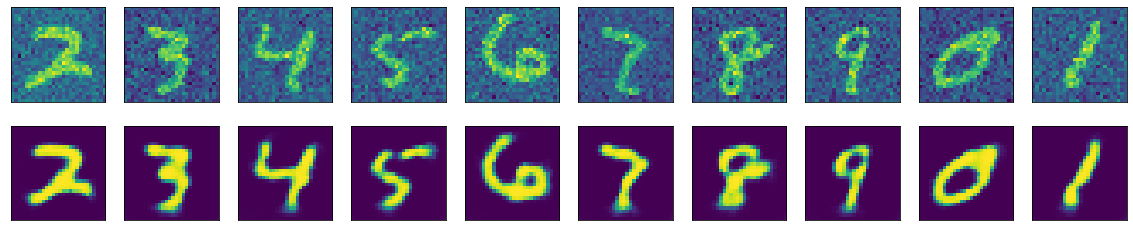

In [43]:
with torch.no_grad():
        number = 10
        plt.figure(figsize=(20, 4))
    
        for index in range(number):
            ax = plt.subplot(2, number, index + 1)
            plt.imshow(test_img[index].cpu().numpy().reshape(28, 28))
         
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            ax = plt.subplot(2, number, index + 1 + number)
            plt.imshow(output[index].cpu().numpy().reshape(28, 28))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()